In [388]:
import pandas as pd
# Zaktualizowanie funkcji load_data o filtr usunięcia wierszy zawierających 'x' lub 'X'

def load_data(file_path):
    # Wczytywanie pliku, zakładając, że jest rozdzielony spacjami/tabulatorami
    df = pd.read_csv(file_path, sep='\s+', header=None, dtype=str)
    
    # Nadanie nazw kolumn
    df.columns = ['chrom1', 'coord1', 'chrom2', 'coord2']
    
    # Usunięcie wierszy, które zawierają 'x' lub 'X'
    df = df[~df.apply(lambda x: 'x' in x.values or 'X' in x.values, axis=1)]
    
    # Konwersja kolumn do odpowiednich typów numerycznych i usunięcie wierszy, które nie zawierają 4 liczb
    for col in ['chrom1', 'coord1', 'chrom2', 'coord2']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna().astype(int)
    
    return df

# Ścieżka do pliku
file_path = "GSM1173493_cell-1.txt"

# Wczytywanie danych
data = load_data(file_path)
# Wyświetlenie wczytanego dataframe
data.head()



,chrom1,coord1,chrom2,coord2
1,1,3023035,1,14942225
2,1,3065457,1,19796342
3,1,3312156,1,5315667
4,1,3377904,1,24338979
5,1,3390558,1,20722058


In [389]:
data = data[(data['chrom1'] == 11) & (data['chrom2'] == 11)]
len(data)

1581

In [390]:
# Skala dla siatki - to jest przykładowa wartość, może wymagać dostosowania
scale_factor = 5000000  # Skala dostosowana do zakresu danych
data['bead1'] = (data['coord1'] // scale_factor).astype(int)
data['bead2'] = (data['coord2'] // scale_factor).astype(int)
data['bead1']=data['bead1']-min(data['bead1'])+1
data['bead2']=data['bead2']-min(data['bead2'])+1
print(max(data['bead1']))
print

25


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [391]:
#usuwanie duplikatow
data = data.drop_duplicates(subset=['bead1', 'bead2'], keep=False)
data['sorted_bead_pair'] = data.apply(lambda x: tuple(sorted((x['bead1'], x['bead2']))), axis=1)
data = data.drop_duplicates(subset=['sorted_bead_pair'], keep=False)
data.drop('sorted_bead_pair', axis=1, inplace=True)
data = data[data['bead1'] != data['bead2']]
print(len(data))

36


## 

In [392]:
combined_values = pd.concat([data['bead1'], data['bead2']]).unique()

# Tworzenie mapowania z oryginalnych wartości na nowe identyfikatory
value_to_id = {value: idx + 1 for idx, value in enumerate(sorted(combined_values))}

# Zastosowanie mapowania do kolumn
data['bead1'] = data['bead1'].map(value_to_id)
data['bead2'] = data['bead2'].map(value_to_id)

In [393]:
import pandas as pd

n=max(max(data['bead1']),max(data['bead2']))

# Krok 2: Znalezienie sąsiadów dla każdej liczby
neighbors = {i: set() for i in range(1, n+1)}  # Używamy zbioru, aby unikać duplikatów

for _, row in data.iterrows():
    bead1, bead2 = row['bead1'], row['bead2']
    neighbors[bead1].add(bead2)  # Dodajemy bead2 do zbioru sąsiadów bead1
    neighbors[bead2].add(bead1)  # Dodajemy bead1 do zbioru sąsiadów bead2
    
    
# Przykład: wypisanie wyników dla pierwszych 10 liczb
for i in range(1, 11):
    print(f"sąsiedzi: {list(neighbors[i])}")
n

sąsiedzi: [3, 6, 8, 10, 14]
sąsiedzi: [17, 7, 15]
sąsiedzi: [1, 19, 15]
sąsiedzi: [11]
sąsiedzi: [16]
sąsiedzi: [1, 12, 17, 15]
sąsiedzi: [2, 19, 12, 21]
sąsiedzi: [1, 18]
sąsiedzi: [16, 11, 19, 15]
sąsiedzi: [1, 19]


22

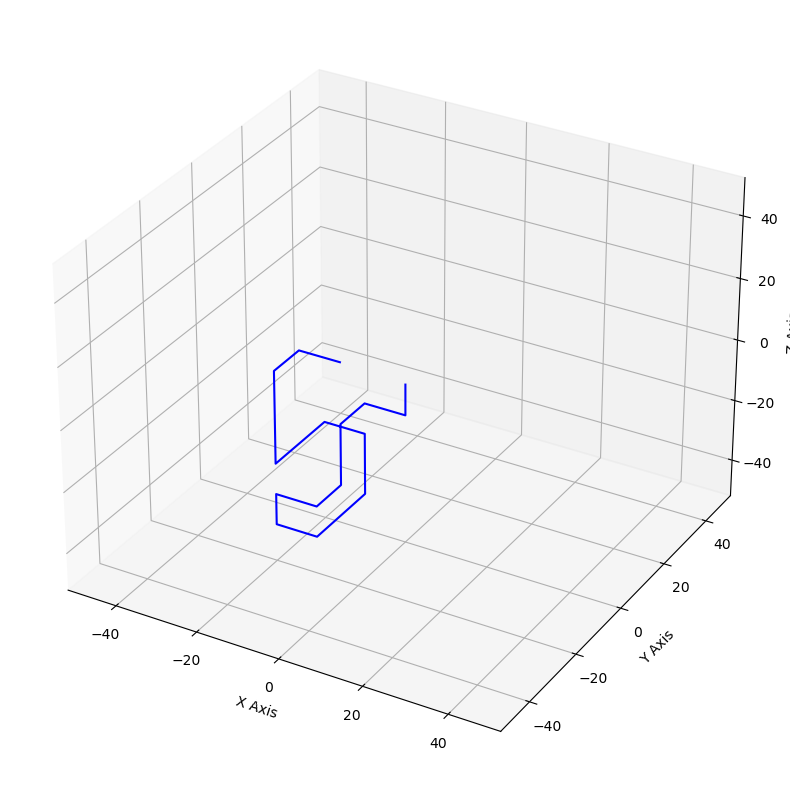

In [394]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Zdefiniujemy funkcję, która realizuje self-avoiding walk (SAW) w siatce 3D.
def self_avoiding_walk_3d(steps, grid_size):
    # Początkowa pozycja w środku siatki
    position = np.array([0,0,0])
    walk = [tuple(position)]
    
    # Potencjalne ruchy
    potential_moves = [np.array(move) for move in [(10, 0, 0), (-10, 0, 0), (0, 10, 0), (0, -10, 0), (0, 0, 10), (0, 0, -10)]]
    
    for _ in range(steps - 1):
        np.random.shuffle(potential_moves)  # Mieszanie możliwych ruchów
        for move in potential_moves:
            new_position = position + move
            if tuple(new_position) not in walk:  # Sprawdzamy, czy nowa pozycja nie była odwiedzona
                position = new_position
                walk.append(tuple(position))
                break
        else:
            # Jeśli żaden ruch nie jest możliwy, kończymy spacer
            break
    
    return walk

# Przeprowadzamy SAW dla 1942 kroków
saw_walk = self_avoiding_walk_3d(steps=n, grid_size=100)

# Konwertujemy spacer na format, który możemy wyświetlić
x_saw, y_saw, z_saw = zip(*saw_walk)

# Tworzenie wykresu SAW
fig_saw = plt.figure(figsize=(10, 10))
ax_saw = fig_saw.add_subplot(111, projection='3d')
ax_saw.plot(x_saw, y_saw, z_saw, c='blue')

# Ustawiamy etykiety osi
ax_saw.set_xlabel('X Axis')
ax_saw.set_ylabel('Y Axis')
ax_saw.set_zlabel('Z Axis')

# Ustawienie limitów osi
ax_saw.set_xlim(-50, 50)
ax_saw.set_ylim(-50, 50)
ax_saw.set_zlim(-50,50)

# Wyświetlamy wykres SAW
plt.show()
coordinates= np.column_stack((x_saw, y_saw, z_saw))



In [395]:
# Definicja sąsiedztwa z indeksami od 1
neighbors = {
    1: [3, 6, 8, 10, 14],
    2: [17, 7, 15],
    3: [1, 19, 15],
    4: [11],
    5: [16],
    6: [1, 12, 17, 15],
    7 : [2, 19, 12, 21],
    8 : [1, 18],
    9 : [16, 11, 19, 15],
    10: [1, 19],
}

# Obliczanie i wyświetlanie odległości
for main_index in neighbors:
    print(f"Odległości dla punktu {main_index} do jego sąsiadów:")
    # Pobieranie punktu głównego, uwzględniając różnicę indeksowania
    main_point = np.array(coordinates[main_index - 1])
    # Przetwarzanie każdego sąsiada
    for neighbor_index in neighbors[main_index]:
        # Pobieranie punktu sąsiada, również z korektą indeksowania
        neighbor_point = np.array(coordinates[neighbor_index - 1])
        # Obliczanie odległości euklidesowej
        distance = np.linalg.norm(main_point - neighbor_point)
        print(f"  do {neighbor_index}: {distance:.2f}")


Odległości dla punktu 1 do jego sąsiadów:
  do 3: 14.14
  do 6: 33.17
  do 8: 41.23
  do 10: 45.83
  do 14: 22.36
Odległości dla punktu 2 do jego sąsiadów:
  do 17: 30.00
  do 7: 30.00
  do 15: 22.36
Odległości dla punktu 3 do jego sąsiadów:
  do 1: 14.14
  do 19: 24.49
  do 15: 14.14
Odległości dla punktu 4 do jego sąsiadów:
  do 11: 30.00
Odległości dla punktu 5 do jego sąsiadów:
  do 16: 10.00
Odległości dla punktu 6 do jego sąsiadów:
  do 1: 33.17
  do 12: 14.14
  do 17: 17.32
  do 15: 17.32
Odległości dla punktu 7 do jego sąsiadów:
  do 2: 30.00
  do 19: 31.62
  do 12: 22.36
  do 21: 42.43
Odległości dla punktu 8 do jego sąsiadów:
  do 1: 41.23
  do 18: 20.00
Odległości dla punktu 9 do jego sąsiadów:
  do 16: 22.36
  do 11: 14.14
  do 19: 40.00
  do 15: 28.28
Odległości dla punktu 10 do jego sąsiadów:
  do 1: 45.83
  do 19: 41.23


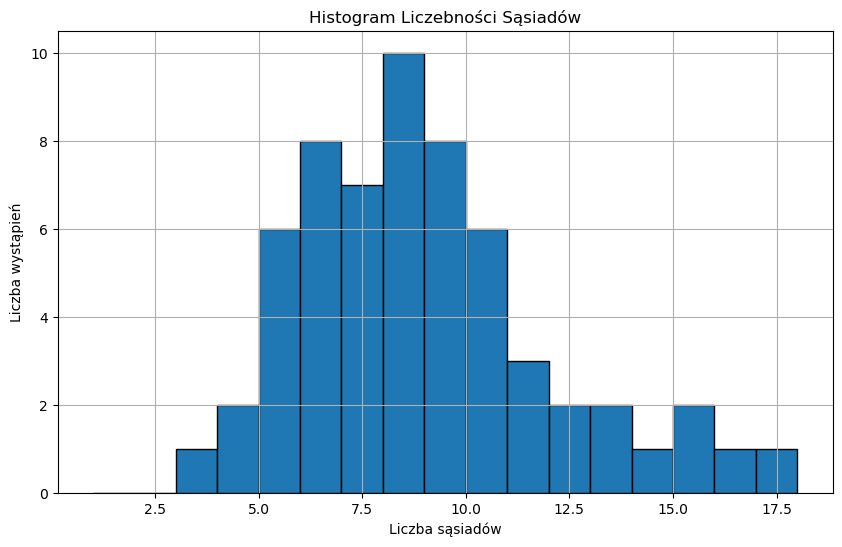

In [396]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(neighbors_count, bins=range(1, max(neighbors_count) + 2), edgecolor='black')
plt.title('Histogram Liczebności Sąsiadów')
plt.xlabel('Liczba sąsiadów')
plt.ylabel('Liczba wystąpień')
plt.grid(True)
plt.show()

In [409]:
import numpy as np
import pandas as pd
from math import exp


def calculate_theta_ij_simple(contact_matrix, i, j, d2, mu2):
    theta_ij_simple = 0

    # Iterujemy przez zakres od i-d0 do i+d0+1 dla xp
    for xp in range(i - d2, i + d2 + 1):
        # Iterujemy przez zakres od j-d0 do j+d0+1 dla yp
        for yp in range(j - d2, j + d2 + 1):
            # Sprawdzamy czy (xp, yp) jest w granicach macierzy
            if 0 <= xp < contact_matrix.shape[0] and 0 <= yp < contact_matrix.shape[1]:
                # Sprawdzamy czy istnieje kontakt
                if contact_matrix[xp, yp] == 1:
                    # Obliczamy wartość funkcji Gaussa i dodajemy do sumy
                    gauss_value = np.exp(-((xp - i)**2 + (yp - j)**2) / mu2)
                    theta_ij_simple += gauss_value

    # Ograniczamy wynik do maksymalnie 1
    theta_ij_simple = min(theta_ij_simple, 1)
    return theta_ij_simple

def calculate_contract_matrix(d2,mu2,n,d,data):
    
    contact_matrix1 = np.zeros((n,n), dtype=int)
    
    for index, row in data.iterrows():
        bead1 = int(row['bead1']) - 1  # Odejmujemy 1, aby indeksowanie było od 0
        bead2 = int(row['bead2']) - 1
        contact_matrix1[bead1, bead2] = 1
        contact_matrix1[bead2, bead1] = 1  # Zapewnienie symetrii
    
    contact_matrix2 = np.zeros((n, n), dtype=float)
        
    for i in range(n):
        for j in range(i):
            contact_matrix2[i][j]=calculate_theta_ij_simple(contact_matrix1,i,j,d2,mu2)
            contact_matrix2[j][i]=contact_matrix2[i][j]
    return contact_matrix2              

import numpy as np
def calculate_loss(contact_matrix2, coordinates, d, p, f, n, mu1, theta1, a, b):
    d1 = d / theta1**(1/3)
    L = 0.0
    for i in range(len(coordinates)):
        for j in range(i):
            dist = np.linalg.norm(coordinates[i] - coordinates[j])  # Obliczenie d(i, j)
            if contact_matrix2[i, j] == 1:
                L += ((dist - d)**2) / (d**2)
            elif contact_matrix2[i, j] > theta1:
                L += a*(1 - np.exp(-((dist - d / (contact_matrix2[i, j]**(1/3)))**2) / mu1))
            else:
                L += b*(1 - 1 / (1 + np.exp(-(dist - (d1 - p)) / f)))
    return L



# Wywołanie funkcji
contact_matrix2=calculate_contract_matrix(int(n/4),0.1,n,4,data[['bead1','bead2']])
loss = calculate_loss(contact_matrix2,coordinates,5,1,0.1,n,20,0.6,1,1)
print("Wartość funkcji straty L:", loss)


Wartość funkcji straty L: 4.229008389076757


In [398]:
contact_matrix2[3]

array([4.53999298e-05, 2.06115362e-09, 1.92874985e-22, 0.00000000e+00,
       1.80485139e-35, 1.92874985e-22, 4.24835426e-18, 1.92874985e-22,
       4.24835426e-18, 4.53999298e-05, 1.00000000e+00, 4.53999298e-05,
       4.24874001e-18, 2.06115362e-09, 4.54019909e-05, 4.54019909e-05,
       2.06115363e-09, 2.06115362e-09, 4.53999298e-05, 2.06115362e-09,
       1.92874985e-22, 7.44015195e-44])

In [411]:
import numpy as np


from itertools import product
import random 

def total_loss_for_bead(contact_matrix2,coordinates,i, d, p, f, theta1,n,a,b,mu1):
    L=0.0
    d1 = d / theta1**(1/3)
    for j in range(n):
            if(j!=i):
                dist = np.linalg.norm(coordinates[i] - coordinates[j])  # Obliczenie d(i, j)
                if contact_matrix2[i, j] == 1:
                    L += ((dist - d)**2) / (d**2)
                elif (contact_matrix2[i, j]>theta1):
                    L+=a*(1-exp(-(dist-d/(contact_matrix2[i,j]**(1/3)))**2/mu1))
                else:
                    L += b*(1 - 1 / (1 + exp(-(dist - (d1 - p)) / f)))
    return L

    
    


import numpy as np
import random

import numpy as np
import random

def make_move_optimized(contact_matrix2, coordinates, d, p, f, theta1, n, a, b, d3, mu1):
    i = random.randint(0, n-1)
    directions = np.array([
        [-1, -1, -1], [-1, -1, 0], [-1, -1, 1], [-1, 0, -1], [-1, 0, 0], [-1, 0, 1],
        [-1, 1, -1], [-1, 1, 0], [-1, 1, 1], [0, -1, -1], [0, -1, 0], [0, -1, 1],
        [0, 0, -1], [0, 0, 1], [0, 1, -1], [0, 1, 0], [0, 1, 1], [1, -1, -1],
        [1, -1, 0], [1, -1, 1], [1, 0, -1], [1, 0, 0], [1, 0, 1], [1, 1, -1],
        [1, 1, 0], [1, 1, 1]
    ])

    coordinate = coordinates[i].copy()
    initial_loss = total_loss_for_bead(contact_matrix2, coordinates, i, d, p, f, theta1, n, a, b, mu1)
    
    changes = []
    for vector in directions:
        new_position = coordinate + vector
        if ((i == 0 or i == n-1) and np.linalg.norm(new_position - coordinates[i + (1 if i == 0 else -1)]) <= d3):
            continue
        if 0 < i < n-1 and (np.linalg.norm(new_position - coordinates[i-1]) > d3 or np.linalg.norm(new_position - coordinates[i+1]) > d3):
            continue
        coordinates[i] = new_position
        new_loss = total_loss_for_bead(contact_matrix2, coordinates, i, d, p, f, theta1, n, a, b, mu1)
        coordinates[i] = coordinate
        loss_change = new_loss - initial_loss
        changes.append((loss_change, new_position))
    
    # Filter and sort changes based on sign
    negative_changes = [(change, pos) for change, pos in changes if change < 0]
    positive_changes = [(change, pos) for change, pos in changes if change >= 0]

    if negative_changes or positive_changes:
        if random.random() < 0.95 and negative_changes:
            # Choose from negative changes with probability proportional to the magnitude of loss change
            weights_neg = [abs(loss) for loss, _ in negative_changes]
            _, chosen_position = random.choices(negative_changes, weights=weights_neg)[0]
        elif positive_changes:
            # Choose from positive changes with probability inversely proportional to the value of loss change
            weights_pos = [1.0 / (loss + 1e-6) for loss, _ in positive_changes]
            _, chosen_position = random.choices(positive_changes, weights=weights_pos)[0]
        else:
            return coordinates  # No valid moves available

        # Update the position if the chosen position is unique
        if is_position_unique(coordinates, chosen_position, i):
            coordinates[i] = chosen_position

    return coordinates
    
    
    
    
    
def make_move(contact_matrix2,coordinates, d, p, f,theta1,n,a,b,d3,mu1):
    
    i=random.randint(0, n-1)
    
    directions = {
    'left-back-down': [-1, -1, -1],
    'left-back': [-1, -1, 0],
    'left-back-up': [-1, -1, 1],
    'left-down': [-1, 0, -1],
    'left': [-1, 0, 0],
    'left-up': [-1, 0, 1],
    'left-forward-down': [-1, 1, -1],
    'left-forward': [-1, 1, 0],
    'left-forward-up': [-1, 1, 1],
    'back-down': [0, -1, -1],
    'back': [0, -1, 0],
    'back-up': [0, -1, 1],
    'down': [0, 0, -1],
    'up': [0, 0, 1],
    'forward-down': [0, 1, -1],
    'forward': [0, 1, 0],
    'forward-up': [0, 1, 1],
    'right-back-down': [1, -1, -1],
    'right-back': [1, -1, 0],
    'right-back-up': [1, -1, 1],
    'right-down': [1, 0, -1],
    'right': [1, 0, 0],
    'right-up': [1, 0, 1],
    'right-forward-down': [1, 1, -1],
    'right-forward': [1, 1, 0],
    'right-forward-up': [1, 1, 1]
    }
    coordinate = coordinates[i].copy()
    best_position=coordinates[i]
    best_loss_change = 0
    initial_loss =  total_loss_for_bead(contact_matrix2,coordinates, i, d, p, f,theta1,n,a,b,mu1)

    for direction, vector in directions.items():
        new_position = coordinate + np.array(vector)
        if ((i == 0 and np.linalg.norm(new_position - coordinates[i+1]) <= d3) or (i == n-1 and np.linalg.norm(new_position - coordinates[i-1]) <= d3)
        or (np.linalg.norm(new_position - coordinates[i-1]) <= d3 and np.linalg.norm(new_position - coordinates[i+1]) <= d3)):
            coordinates[i] = new_position
            new_loss =   total_loss_for_bead(contact_matrix2,coordinates, i, d, p, f,theta1,n,a,b,mu1)
            if (new_loss - initial_loss) < best_loss_change:
                best_loss_change = new_loss - initial_loss
                best_position = new_position
            coordinates[i]=coordinate
    
    
    if(best_loss_change<0):
        if(is_position_unique(coordinates,best_position,i)):
            coordinates[i]=best_position


def is_position_unique(coordinates, best_position, current_index):
    # Przeszukaj wszystkie koordynaty z wyjątkiem koordynatu na indeksie 'current_index'
    for index, pos in enumerate(coordinates):
        if index != current_index:
            # Sprawdź, czy nowa pozycja pokrywa się z istniejącą
            if np.allclose(pos, best_position):
                return False
    return True







  

for j in range(20000):
    #(contact_matrix2,coordinates, d, p, f,theta1,n,a,b,d3,mu1):
    make_move_optimized(contact_matrix2,coordinates,5,1,0.1,0.7,n,1,5,50,10)
    if(j%500==499):
        #def calculate_loss(contact_matrix2, coordinates, d, p, f, n, mu1, theta1, a, b):
        loss=calculate_loss(contact_matrix2, coordinates, 5, 1, 0.1,n,1,0.6,1,4)
        print(loss)
        unique_rows = np.unique(coordinates, axis=0)
        print(unique_rows.shape[0])
        if(loss<5):
            break

7.097827624342886
22
12.533169161728047
22
9.938086195400514
22
4.218526704928335
22


In [400]:
from points_io import point_reader, save_points_as_pdb
import pandas as pd
import numpy as np
data1 = np.array(np.unique(coordinates, axis=0))
save_points_as_pdb(data1, '420692137666.pdb')

File 420692137666.pdb saved...


In [412]:
# Definicja sąsiedztwa z indeksami od 1
neighbors = {
    1: [3, 6, 8, 10, 14],
    2: [17, 7, 15],
    3: [1, 19, 15],
    4: [11],
    5: [16],
    6: [1, 12, 17, 15],
    7 : [2, 19, 12, 21],
    8 : [1, 18],
    9 : [16, 11, 19, 15],
    10: [1, 19],
}

# Obliczanie i wyświetlanie odległości
for main_index in neighbors:
    print(f"Odległości dla punktu {main_index} do jego sąsiadów:")
    # Pobieranie punktu głównego, uwzględniając różnicę indeksowania
    main_point = np.array(coordinates[main_index - 1])
    # Przetwarzanie każdego sąsiada
    for neighbor_index in neighbors[main_index]:
        # Pobieranie punktu sąsiada, również z korektą indeksowania
        neighbor_point = np.array(coordinates[neighbor_index - 1])
        # Obliczanie odległości euklidesowej
        distance = np.linalg.norm(main_point - neighbor_point)
        print(f"  do {neighbor_index}: {distance:.2f}")


Odległości dla punktu 1 do jego sąsiadów:
  do 3: 5.74
  do 6: 8.12
  do 8: 6.40
  do 10: 6.78
  do 14: 6.78
Odległości dla punktu 2 do jego sąsiadów:
  do 17: 4.58
  do 7: 5.10
  do 15: 6.08
Odległości dla punktu 3 do jego sąsiadów:
  do 1: 5.74
  do 19: 6.16
  do 15: 2.45
Odległości dla punktu 4 do jego sąsiadów:
  do 11: 5.10
Odległości dla punktu 5 do jego sąsiadów:
  do 16: 4.36
Odległości dla punktu 6 do jego sąsiadów:
  do 1: 8.12
  do 12: 6.40
  do 17: 5.20
  do 15: 5.39
Odległości dla punktu 7 do jego sąsiadów:
  do 2: 5.10
  do 19: 7.14
  do 12: 5.92
  do 21: 4.24
Odległości dla punktu 8 do jego sąsiadów:
  do 1: 6.40
  do 18: 6.16
Odległości dla punktu 9 do jego sąsiadów:
  do 16: 5.10
  do 11: 3.46
  do 19: 3.74
  do 15: 7.07
Odległości dla punktu 10 do jego sąsiadów:
  do 1: 6.78
  do 19: 7.14
